In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import statsmodels.api as sm
import pandas as pd

tickerSymbol = 'SPY'

data = pd.read_csv("data_stocks/AAL.csv")

data.index = pd.to_datetime(data["ts_event"])
data.drop(columns = "ts_event", inplace=True)
display(data)


,open,high,low,close,volume
ts_event,,,,,
2018-05-01,42880000000,43450000000,42560000000,43360000000,1871441
2018-05-02,43230000000,43410000000,42140000000,42250000000,2379753
2018-05-03,42240000000,42460000000,41540000000,42120000000,1793068
2018-05-04,41990000000,43440000000,41750000000,42900000000,2196152
2018-05-07,43250000000,43250000000,42130000000,42430000000,1810560
...,...,...,...,...,...
2024-01-22,13640000000,14190000000,13545000000,13980000000,5857543
2024-01-23,13990000000,14470000000,13935000000,14100000000,8035619
2024-01-24,14050000000,14240000000,13855000000,13940000000,7007363


In [6]:
# ARMA

ts = data['Close']

# The order (p,q) needs to be specified
# p: number of autoregressive terms, q: number of moving average terms
model = sm.tsa.arima.ARIMA(ts, order=(1,0,1))
results = model.fit()

# Summary of the model
print(results.summary())


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  war

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2514
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -6572.163
Date:                Mon, 29 Jan 2024   AIC                          13152.326
Time:                        10:22:31   BIC                          13175.645
Sample:                             0   HQIC                         13160.790
                               - 2514                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        282.2240    179.871      1.569      0.117     -70.317     634.764
ar.L1          0.9998      0.001   1430.005      0.000       0.998       1.001
ma.L1         -0.0693      0.010     -6.953      0.0

Iteration 0


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,1,2)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py", line 704, in fit
    mlefit = su

Iteration 50
Iteration 100


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,1)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py", line 704, in fit
    mlefit = su

Iteration 150


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py", line 704, in fit
    mlefit = su

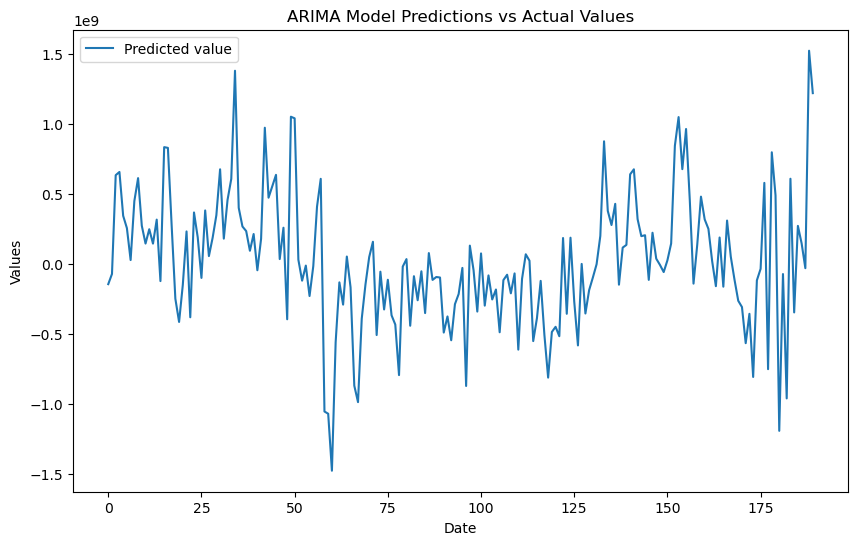

0.9377304113596509
2.2543662733198442e+17


In [7]:
import matplotlib.pyplot as plt
import pmdarima as pm
import numpy as np
from sklearn.metrics import r2_score  as r2
from sklearn.metrics import mean_squared_error as mse


# ARIMA
ts = data['close'].to_numpy()[-200:]

trainWindow = 10

ytrue = ts[trainWindow:]
ypred = []
index = [i for i in range(len(ytrue))]

for i in range(len(ytrue)):
    trainSet = ts[i:i+trainWindow]
    model = pm.auto_arima(trainSet)
    ypred.append(model.predict(n_periods = 1)[0])
    
    if i%50 == 0:
        print("Iteration", i)
    



# Make predictions
predictions = model.predict(n_periods = 1)

# Plotting the results
plt.figure(figsize=(10, 6))
#plt.plot(index, ytrue, label='Reel value')
#plt.plot(index, ypred, label='Predicted value')
plt.plot(index, np.subtract(ytrue,ypred), label='Predicted value')
plt.title('ARIMA Model Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

print(r2(ytrue,ypred))
print(mse(ytrue,ypred))